In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/571_Project

/content/gdrive/MyDrive/571_Project


In [3]:
import pandas as pd
import pickle
import numpy as np
import nltk
from nltk.corpus import stopwords
import keras
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import string
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.pipeline import make_union
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import joblib


In [4]:
# Global random state and k-fold strategy
seed = 42
k = 5
cv = StratifiedKFold(n_splits=k)


In [5]:
def f1_score_func(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [6]:
def feature_engineering(df, sparse=0):

    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))

    # Count profanity words
    profanity_words = ['f[u\*]ck', 'sh[i\*]t', 'a[s\$]shole', 'b[i\*]tch', 'd[i\*]ck', 'p[u\*]ssy', 'b[a\*]stard', 's[l\*]ut', 'wh[o\*]re', 'st[u\*]pid', 'd[u\*]mb']
    profanity_pattern = r'\b(' + '|'.join(profanity_words) + r')\b'
    df['profanity_count'] = df.comment_text.str.findall(profanity_pattern).str.len()


    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Mean Word length
    def word_length(s):
        s = s.split(' ')
        return np.mean([len(w) for w in s if w.isalpha()])
    df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

    # Average number of exclamation points
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))

    # Normalize
    for label in ['length', 'profanity_count','caps', 'word_length', 'question', 'exclamation']:
        minimum = df[label].min()
        diff = df[label].max() - minimum
        df[label] = df[label].apply(lambda x: (x-minimum) / (diff))

    # Strip IP Addresses
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))

    return df

def merge_features(comment_text, data, engineered_features):
    new_features = sparse.csr_matrix(df[engineered_features].values)
    if np.isnan(new_features.data).any():
        new_features.data = np.nan_to_num(new_features.data)
    return sparse.hstack([comment_text, new_features])


In [7]:
# Reset data and create holdout set.

df = pd.read_csv('train.csv')
targets = list(df.columns[2:])
df_targets = df[targets].copy()

df_sub = pd.read_csv('test.csv', dtype={'id': object}, na_filter=False)

submission = pd.DataFrame()
submission['id'] = df_sub.id.copy()

# Feature Engineering
df = feature_engineering(df)
df_sub = feature_engineering(df_sub)

print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)


print('\nSubmission data')
df_sub.drop('id', inplace=True, axis=1)
print(list(df_sub.columns))
print(df_sub.shape)

toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)
targets.append('any_label')
df_targets['any_label'] = toxic_rows.astype(int)

new_features = list(df.columns[1:])
print(new_features)

from sklearn.model_selection import train_test_split
df, holdout, df_targets, holdout_targets = train_test_split(df, df_targets, test_size=0.2, random_state=seed)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
new_features


['length', 'profanity_count', 'caps', 'word_length', 'exclamation', 'question']

In [ ]:
from sklearn.base import clone
#todo
# Weights for
def multi_cv(model, data, labels, k=5, nb_features=False):
    cv = StratifiedKFold(n_splits=k)
    # Creating NB features just once from any_label has about the same
    # performance as individual labels with faster speed.
    def log_count_ratio(x, y):
        x = sparse.csr_matrix(x)
        # WARNING: Some scipy modules use indexes that start at 1!
        # You need to add 1 to an index when performing operations on a csr_matrix

        p = abs(x[np.where(y==1)].sum(axis=0))
        p = p + 1
        p = p / np.sum(p)

        q = abs(x[np.where(y==0)].sum(axis=0))
        q = q + 1
        q = q / np.sum(q)

        return np.log(p/q)

    # Labels must be in a dataframe
    scores = []
    r_values = []
    for label in labels.columns:
        if nb_features:
            r = log_count_ratio(data, labels[label])
            r_values.append(r)
            data = data.multiply(r)
            if np.isnan(data.data).any():
                data.data = np.nan_to_num(data.data)
        score = np.mean(cross_val_score(clone(model), data, labels[label], scoring='f1', cv=cv))
        print(label + ' f1 score: %.4f' % score)
        scores.append(score)
    print('Average (excluding any) f1 score: %.4f' % np.mean(scores[:-1]))
    if nb_features:
        return scores, r_values
    else:
        return scores

#training_comments.data = np.nan_to_num(training_comments.data)

#model = LinearSVC()
#_ = multi_cv(model, training_comments, df_targets, nb_features=True)

In [ ]:
class NBFeatures:
    def __init__(self, epsilon=1, sparse=True):
        # How much influence NB features have
        if not epsilon > 0 and epsilon <= 1:
            raise Exception("Invalid Epsilon value. Must be greater than zero and less than or equal to one.")
        self.epsilon = epsilon
        self.r = None

    def log_count_ratio(self, x, y):
        x = sparse.csr_matrix(x)
        # WARNING: Some scipy authors fall in the "index starts at 1" camp
        # You need to add 1 to an index when performing operations on a csr_matrix
        p = abs(x[np.where(y==1)].sum(axis=0))
        p = p + 1
        p = p / np.sum(p)
        q = abs(x[np.where(y==0)].sum(axis=0))
        q = q + 1
        q = q / np.sum(q)
        return np.log(p/q)

    def fit(self, x, y):
        self.r = self.log_count_ratio(x, y)

    def transform(self, x):
        if self.r.all()==None:
            raise Exception("Model not fit, can't transform.")
        transformed = x.multiply(self.r)
        return x.multiply(1-self.epsilon) + transformed.multiply(self.epsilon)
    def fit_transform(self, x, y):
        self.r = self.log_count_ratio(x, y)
        return self.transform(x, y)


#nb_trans = NBFeatures(0.5)
#new = nb_trans.fit_transform(training_comments, np.array(df_targets.iloc[:,-1]))
#nb_trans.r.shape

In [ ]:
def log_count_ratio(x, y):
    x = sparse.csr_matrix(x)
    # WARNING: Some scipy authors fall in the "index starts at 1" camp
    # You need to add 1 to an index when performing operations on a csr_matrix

    p = abs(x[np.where(y==1)].sum(axis=0))
    p = p + 1
    p = p / np.sum(p)

    q = abs(x[np.where(y==0)].sum(axis=0))
    q = q + 1
    q = q / np.sum(q)

    return np.log(p/q)

In [ ]:
comment_vector = TfidfVectorizer(max_features=10000, analyzer='word', #ngram_range=(2, 6),
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)
holdout_comments = comment_vector.transform(holdout.comment_text)
submission_comments = comment_vector.transform(df_sub.comment_text)

print(training_comments.shape)

(127656, 10000)


In [ ]:
for target in targets:
    lr = LogisticRegression(random_state=seed)
    print(target + ' score: %.4f' % np.mean(cross_val_score(lr, merge_features(training_comments, df, new_features), df_targets[target], scoring='f1', cv=cv)))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.mi

toxic score: 0.7236
severe_toxic score: 0.3497
obscene score: 0.7443
threat score: 0.2028


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


insult score: 0.6276
identity_hate score: 0.2756


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.mi

any_label score: 0.7327
Elapsed time was 2:17.


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


In [ ]:
model = MultinomialNB(alpha=1.0)
_ = multi_cv(model, merge_features(training_comments, df, new_features), df_targets)

toxic f1 score: 0.6663
severe_toxic f1 score: 0.1045
obscene f1 score: 0.6745
threat f1 score: 0.0000
insult f1 score: 0.5714
identity_hate f1 score: 0.0387
any_label f1 score: 0.6734
Average (excluding any) f1 score: 0.3426
Elapsed time was 0:02.


In [ ]:
model = LinearSVC(random_state=seed)
_ = multi_cv(model, merge_features(training_comments, df, new_features), df_targets)

toxic f1 score: 0.7595
severe_toxic f1 score: 0.3505
obscene f1 score: 0.7794
threat f1 score: 0.3656
insult f1 score: 0.6647
identity_hate f1 score: 0.3540
any_label f1 score: 0.7739
Average (excluding any) f1 score: 0.5456
Elapsed time was 0:35.


In [ ]:
nb = NBFeatures()
nb.fit(training_comments, df_targets.any_label)
nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)

In [ ]:
#With engineered features.

train_data = lgb.Dataset(merge_features(training_comments, df, new_features), label=df_targets.any_label.values)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 1,
    'num_leaves': 64,
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 16,
    'n_jobs': -1,
    'seed': seed
}

cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100,
        nfold=5,
        metrics='mae',
        #early_stopping_rounds=10,
        feval=f1_score_func
        )
print("Final CV F1 score is %.4f" % cv_results['f1-mean'][-1])

[LightGBM] [Info] Number of positive: 10384, number of negative: 91740
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 19.184047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601186
[LightGBM] [Info] Number of data points in the train set: 102124, number of used features: 9755
[LightGBM] [Info] Number of positive: 10385, number of negative: 91740
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 13.787971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601186
[LightGBM] [Info] Number of data points in the train set: 102125, number of used features: 9755
[LightGBM] [Info] Number of positive: 10385, number of negative: 91740
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 14.298101 seconds.
You can set `force_

In [ ]:
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', ngram_range=(2,6),
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)

print(training_comments.shape)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)


Elapsed time was 2:04.
(127656, 30000)
0.4170647922820832
Elapsed time was 0:28.


In [ ]:
#svm parameter tuning

word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2),
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df.comment_text)

print(training_comments.shape)

# Reset NB feature transformer epsilon value
nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df, new_features), df_targets.any_label)
input_data = nb_eng.transform(merge_features(training_comments, df, new_features))

Elapsed time was 3:14.
(127656, 30000)


In [ ]:
#Model Evaluation Optimimum Model
import joblib

# TF-IDF Vectorization
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2),
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)

# Fit to and transform input data
X_train = vectorizer.fit_transform(df.comment_text)
X_test = vectorizer.transform(holdout.comment_text)

# Name training target data
y_train = df_targets.any_label
y_test = holdout_targets.any_label

# Create and fit NB Feature extractor
nb = NBFeatures()
nb.fit(X_train, y_train)

# Tranform input data
X_train = nb.transform(X_train)
X_test = nb.transform(X_test)


# Define model and fit to data
model = LinearSVC(random_state=seed, C=0.5)
model.fit(X_train, y_train)
joblib.dump(model, 'SVM_NB_model.joblib')

['SVM_NB_model.joblib']

In [ ]:
model = joblib.load('SVM_NB_model.joblib')
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

acc = (tp+tn)/(tn+fn+tp+fp)
print("True Positives: %d" % tp)
print("False Positives: %d" % fp)
print("True Negatives: %d" % tn)
print("False Negatives: %d" % fn)
print("Precision: %.4f" % (tp/(tp+fp)))
print("Recall: %.4f" % (tp/(tp+fn)))
print("F1 Score: %.4f" % f1_score(y_test, y_pred))
print("Total Accuracy: %.2f%%" % acc)

True Positives: 2386
False Positives: 282
True Negatives: 28389
False Negatives: 858
Precision: 0.8943
Recall: 0.7355
F1 Score: 0.8072
Total Accuracy: 0.96%


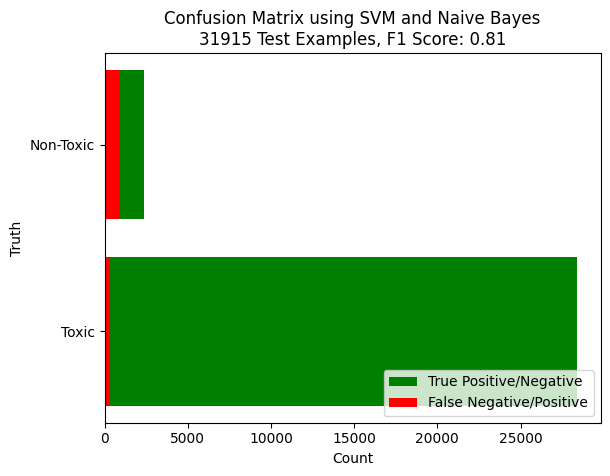

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the test data
y_pred = model.predict(X_test)

# Calculate the confusion matrix and F1 score
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate true/false positive/negative counts
tp = cm[1, 1]
fp = cm[0, 1]
tn = cm[0, 0]
fn = cm[1, 0]

# Display the confusion matrix as a horizontal bar chart
plt.barh([1, 0], [tp, tn], color='g', label='True Positive/Negative')
plt.barh([1, 0], [fn, fp], color='r', label='False Negative/Positive')
plt.yticks([0, 1], ['Toxic', 'Non-Toxic'])
plt.legend(loc='lower right')
plt.title('Confusion Matrix using SVM and Naive Bayes\n' +
          f'{len(y_test)} Test Examples, F1 Score: {f1:.2f}')
plt.xlabel('Count')
plt.ylabel('Truth')
plt.show()


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # modified import statement
from sklearn.model_selection import train_test_split
import numpy as np

# Use pre-trained word embeddings (GloVe)
glove_path = '/content/gdrive/MyDrive/571_Project/glove.6B.100d.txt'
embedding_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.comment_text)

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df.comment_text)

# Pad sequences to a fixed length
max_len = 200
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df_targets.any_label, test_size=0.2, random_state=seed)

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the LSTM model
with tf.distribute.MirroredStrategy().scope():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)
model.save('/content/gdrive/MyDrive/571_Project/my_model.h5')

Epoch 1/3
1596/1596 [==============================] - 1571s 982ms/step - loss: 0.1671 - accuracy: 0.9401 - val_loss: 0.1336 - val_accuracy: 0.9505
Epoch 2/3
1596/1596 [==============================] - 1413s 885ms/step - loss: 0.1280 - accuracy: 0.9531 - val_loss: 0.1273 - val_accuracy: 0.9554
Epoch 3/3
1420/1596 [=========================>....] - ETA: 2:34 - loss: 0.1146 - accuracy: 0.9579

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # modified import statement

# Load the saved model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/571_Project/my_model.h5')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.comment_text)

# Vectorize the holdout data
holdout_vectors = vectorizer.transform(holdout.comment_text)

# Pad the sequences of holdout data
max_len = 200
padded_holdout_sequences = pad_sequences(tokenizer.texts_to_sequences(holdout.comment_text), maxlen=max_len)

# Generate binary predictions for the holdout data
y_pred = model.predict(padded_holdout_sequences)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Print the binary predictions
print(y_pred_binary)



998/998 [==============================] - 110s 110ms/step
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

acc = (tp+tn)/(tn+fn+tp+fp)
print("True Positives: %d" % tp)
print("False Positives: %d" % fp)
print("True Negatives: %d" % tn)
print("False Negatives: %d" % fn)
print("Precision: %.4f" % (tp/(tp+fp)))
print("Recall: %.4f" % (tp/(tp+fn)))
print("F1 Score: %.4f" % f1_score(y_test, y_pred_binary))
print("Total Accuracy: %.2f%%" % acc)

True Positives: 2392
False Positives: 361
True Negatives: 28310
False Negatives: 852
Precision: 0.8689
Recall: 0.7374
F1 Score: 0.7977
Total Accuracy: 0.96%


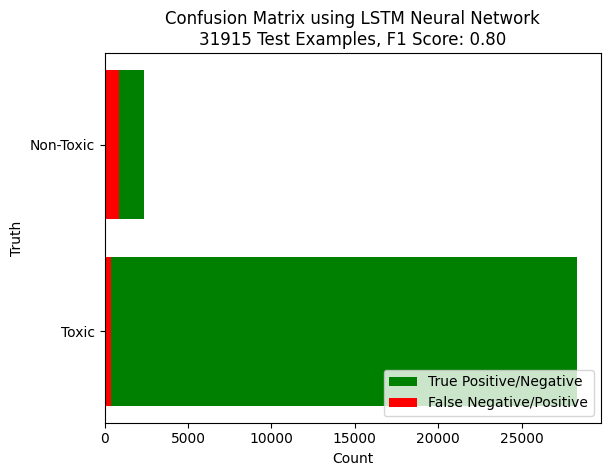

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix and F1 score
cm = confusion_matrix(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Calculate true/false positive/negative counts
tp = cm[1, 1]
fp = cm[0, 1]
tn = cm[0, 0]
fn = cm[1, 0]

# Display the confusion matrix as a horizontal bar chart
plt.barh([1, 0], [tp, tn], color='g', label='True Positive/Negative')
plt.barh([1, 0], [fn, fp], color='r', label='False Negative/Positive')
plt.yticks([0, 1], ['Toxic', 'Non-Toxic'])
plt.legend(loc='lower right')
plt.title('Confusion Matrix using LSTM Neural Network\n' +
          f'{len(y_test)} Test Examples, F1 Score: {f1:.2f}')
plt.xlabel('Count')
plt.ylabel('Truth')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2),
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)

# Fit to and transform input data
X_train = vectorizer.fit_transform(df.comment_text)
X_test = vectorizer.transform(holdout.comment_text)

# Name training target data
y_train = df_targets.any_label
y_test = holdout_targets.any_label

# Define model and fit to data
model = RandomForestClassifier(random_state=seed, n_estimators=100)
model.fit(X_train, y_train)
joblib.dump(model, 'Random_Forest_model.joblib')


['Random_Forest_model.joblib']

In [ ]:
model = joblib.load('Random_Forest_model.joblib')
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

acc = (tp+tn)/(tn+fn+tp+fp)
print("True Positives: %d" % tp)
print("False Positives: %d" % fp)
print("True Negatives: %d" % tn)
print("False Negatives: %d" % fn)
print("Precision: %.4f" % (tp/(tp+fp)))
print("Recall: %.4f" % (tp/(tp+fn)))
print("F1 Score: %.4f" % f1_score(y_test, y_pred))
print("Total Accuracy: %.2f%%" % acc)

True Positives: 1683
False Positives: 83
True Negatives: 28588
False Negatives: 1561
Precision: 0.9530
Recall: 0.5188
F1 Score: 0.6719
Total Accuracy: 0.95%


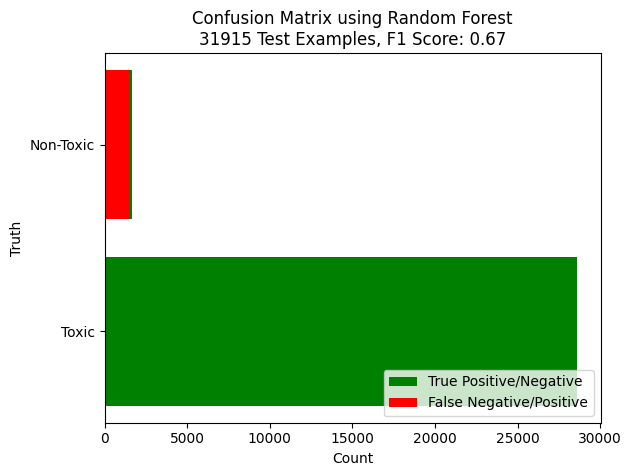

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the test data
y_pred = model.predict(X_test)

# Calculate the confusion matrix and F1 score
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate true/false positive/negative counts
tp = cm[1, 1]
fp = cm[0, 1]
tn = cm[0, 0]
fn = cm[1, 0]

# Display the confusion matrix as a horizontal bar chart
plt.barh([1, 0], [tp, tn], color='g', label='True Positive/Negative')
plt.barh([1, 0], [fn, fp], color='r', label='False Negative/Positive')
plt.yticks([0, 1], ['Toxic', 'Non-Toxic'])
plt.legend(loc='lower right')
plt.title('Confusion Matrix using Random Forest\n' +
          f'{len(y_test)} Test Examples, F1 Score: {f1:.2f}')
plt.xlabel('Count')
plt.ylabel('Truth')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

# TF-IDF Vectorization
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2),
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)

# Fit to and transform input data
X_train = vectorizer.fit_transform(df.comment_text)
X_test = vectorizer.transform(holdout.comment_text)

# Name training target data
y_train = df_targets.any_label
y_test = holdout_targets.any_label

# Define model and fit to data
model = LogisticRegression(random_state=seed, C=0.5)
model.fit(X_train, y_train)
joblib.dump(model, 'Logistic_Regression_model.joblib')


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


['Logistic_Regression_model.joblib']

In [ ]:
model = joblib.load('Logistic_Regression_model.joblib')
y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

acc = (tp+tn)/(tn+fn+tp+fp)
print("True Positives: %d" % tp)
print("False Positives: %d" % fp)
print("True Negatives: %d" % tn)
print("False Negatives: %d" % fn)
print("Precision: %.4f" % (tp/(tp+fp)))
print("Recall: %.4f" % (tp/(tp+fn)))
print("F1 Score: %.4f" % f1_score(y_test, y_pred))
print("Total Accuracy: %.2f%%" % acc)

True Positives: 2079
False Positives: 153
True Negatives: 28518
False Negatives: 1165
Precision: 0.9315
Recall: 0.6409
F1 Score: 0.7593
Total Accuracy: 0.96%


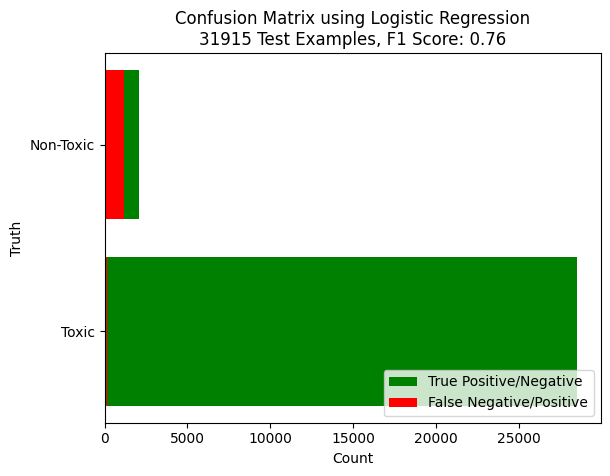

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the test data
y_pred = model.predict(X_test)

# Calculate the confusion matrix and F1 score
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate true/false positive/negative counts
tp = cm[1, 1]
fp = cm[0, 1]
tn = cm[0, 0]
fn = cm[1, 0]

# Display the confusion matrix as a horizontal bar chart
plt.barh([1, 0], [tp, tn], color='g', label='True Positive/Negative')
plt.barh([1, 0], [fn, fp], color='r', label='False Negative/Positive')
plt.yticks([0, 1], ['Toxic', 'Non-Toxic'])
plt.legend(loc='lower right')
plt.title('Confusion Matrix using Logistic Regression\n' +
          f'{len(y_test)} Test Examples, F1 Score: {f1:.2f}')
plt.xlabel('Count')
plt.ylabel('Truth')
plt.show()
